# Imports

from bs4 import BeautifulSoup
import requests
import datetime
import time
import pandas as pd
import numpy as np
import json
import re
from pprint import pprint
import csv
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
import requests
import datetime
import time
import pandas as pd
import numpy as np
import json
import re
from pprint import pprint
import csv
import pickle

import warnings
warnings.filterwarnings('ignore')

In [79]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from textatistic import Textatistic
from textblob import TextBlob
from scipy import stats
from scipy.special import inv_boxcox

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 
%matplotlib inline
sns.set_style(style='darkgrid')
plt.rcParams["patch.force_edgecolor"]=True

# Full Dataset

In [ ]:
#read in the large 1.4 million entry csv file.
kiva_big = pd.read_csv('/Users/travis/Downloads/kiva_ds_csv/loans.csv')
#kiva_big = pd.read_json('/Users/travis/Downloads/kiva_ds_json/loans.json')

In [ ]:
#find places without a translated description and copy over the original so I can drop the description column
kiva_big.DESCRIPTION_TRANSLATED.fillna(kiva_big.DESCRIPTION, inplace=True)

In [ ]:
#Drop rows where there is no description
kiva_big.dropna(axis=0, how='any', subset=['DESCRIPTION'], inplace=True)

In [ ]:
kiva_big.drop(['LOAN_NAME', 'DESCRIPTION', 'NUM_JOURNAL_ENTRIES',
               'NUM_BULK_ENTRIES', 'LOAN_USE','BORROWER_NAMES',
               'BORROWER_PICTURED','VIDEO_ID'],
             axis=1,
             inplace=True)

kiva_big.drop(['CURRENCY'], axis=1, inplace=True)

kiva_big.drop(['CURRENCY_EXCHANGE_COVERAGE_RATE'], axis=1, inplace=True)

kiva_big.drop(['COUNTRY_CODE'], axis=1, inplace=True)

kiva_big.drop(['NUM_LENDERS_TOTAL'], axis=1, inplace=True)

kiva_big.drop(['ACTIVITY_NAME'], axis=1, inplace=True)

In [ ]:
#this gives me percent of rows that have 'TAGS' as null. 55%, keeping this column, can turn into categorical (either yes/no) and use for testing
kiva_big['TAGS'].isnull().mean()

In [ ]:
kiva_big['PARTNER_ID']

In [ ]:
kiva_big.to_pickle('kiva_full.pkl')

In [ ]:
#len(re.findall(r'\w+', kiva_big['DESCRIPTION'][1]))

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(kiva_big.head(1))

In [ ]:
#find values where it is direct funding and the loan either did not receive full funding or is actively fundraising
kiva_big[(kiva_big['LOAN_AMOUNT'] > kiva_big['FUNDED_AMOUNT']) & (kiva_big['DISTRIBUTION_MODEL'] == 'direct')]

## outdated, ignore

tried to use this to load the Json, it did not work and just ran my computer into the ground.
```python
max_records = 1e5
df = pd.read_json(file, lines=True, chunksize=max_records)
filtered_data = pd.DataFrame()
try:
    for df_chunk in df:
        filtered_data = pd.concat([filtered_data, df_chubnk])
except ValueError:
    print('\nData Cannot be Parsed')
```

In [ ]:
#outdated
#kiva_full.drop(['ORIGINAL_LANGUAGE', 'DESCRIPTION_TRANSLATED',
#           'IMAGE_ID', 'VIDEO_ID', 'TOWN_NAME', 'TAGS', 'BORROWER_NAMES',
#           'BORROWER_PICTURED', 'LOAN_USE', 'COUNTRY_CODE'],
#          axis=1,
#          inplace=True)

# Creating 50K Sample

In [ ]:
kiva = kiva_big.sample(50000)

In [ ]:
kiva = kiva.reset_index()

In [ ]:
kiva.drop('index', axis=1, inplace=True)

In [ ]:
#kiva.to_pickle('kiva_423.pkl')

In [ ]:
kiva['DISBURSE_TIME'] = pd.to_datetime(kiva['DISBURSE_TIME'])
kiva['PLANNED_EXPIRATION_TIME'] = pd.to_datetime(kiva['PLANNED_EXPIRATION_TIME'])
kiva['RAISED_TIME'] = pd.to_datetime(kiva['RAISED_TIME'])
kiva['POSTED_TIME'] = pd.to_datetime(kiva['POSTED_TIME'])

In [ ]:
kiva['TIME_DELTA'] = kiva['RAISED_TIME'] - kiva['POSTED_TIME']

In [ ]:
#run to create a days column of number of days it takes a project to get funding.
kiva['DAYS_TO_FUND'] = kiva['TIME_DELTA']/np.timedelta64(1,'D')

In [ ]:
#ensure that the timedelta for Days is a value greater than 0
def cleanDays(row):
    a = row.DAYS_TO_FUND
    if a<0:
        return np.nan
    else:
        return a

In [ ]:
#apply the function cleanDays to the dataframe reassigning negative values to nan. Time must pass forward!
#run when first creating the days column
kiva['DAYS_TO_FUND'] = kiva.apply(cleanDays, axis=1)

In [ ]:
#I found errors in the date posted column, that come with the initial csv.
#I cannot identify those without searching 1x1. but kiva has an upper limit on funding periods
#So anything beyond 60 days I set to nan to catch those errors (less than .5% of this sample is effected)
#This is not guaranteed to catch all errors of this type, but it catches many
#if length of time to get funding is more than 60 days, convert to nan
kiva['DAYS_TO_FUND'][kiva['DAYS_TO_FUND'] >=60] = np.nan

In [ ]:
# def clean_log_funded(row):
#     a = row.LOG_FUNDED
#     if a<0:
#         return np.nan
#     else:
#         return a

In [ ]:
# #run to scale the funding amount by log and drop null values
# kiva['LOG_FUNDED'] = np.log(kiva['FUNDED_AMOUNT'].dropna())
# #run to clean LOG_FUNDED column
# kiva['LOG_FUNDED'] = kiva.apply(clean_log_funded, axis=1)

In [ ]:
#create columnns of number of female borrowers and male borrowers per loan and total number of borrowers
kiva['FEMALE_BORROWERS'] = kiva['BORROWER_GENDERS'].str.title().str.count('Female')
kiva['MALE_BORROWERS'] = kiva['BORROWER_GENDERS'].str.title().str.count('Male')
kiva['BORROWERS_TOTAL'] = kiva['FEMALE_BORROWERS'] + kiva['MALE_BORROWERS']
kiva['PRIMARY_GENDER'] = kiva['FEMALE_BORROWERS'] - kiva['MALE_BORROWERS']

In [ ]:
#Extracts the year from the year the loan request was posted
kiva['YEAR'] = kiva['POSTED_TIME'].dt.year

In [ ]:
#Create a column of the month posted, to see if things fund faster in different times of year
kiva['MONTH'] = kiva['POSTED_TIME'].dt.month

In [ ]:
#Set Primary gender to 1 if there are more female borrowers than male borrowers
kiva['PRIMARY_GENDER'][(kiva['FEMALE_BORROWERS'] - kiva['MALE_BORROWERS'] >=0)] = 'Female'
kiva['PRIMARY_GENDER'][((kiva['FEMALE_BORROWERS'] - kiva['MALE_BORROWERS']) <0)] = 'Male'

In [ ]:
kiva['PERCENT_FEMALE']= (kiva['FEMALE_BORROWERS'] / kiva['BORROWERS_TOTAL'])

In [ ]:
kiva['PERCENT_FEMALE_GROUPED'] = 0

#break into clusters
kiva['PERCENT_FEMALE_GROUPED'][(kiva['PERCENT_FEMALE'] == 0)] = 0
kiva['PERCENT_FEMALE_GROUPED'][(kiva['PERCENT_FEMALE'] > 0) & (kiva['PERCENT_FEMALE'] <=.33)] = .25
kiva['PERCENT_FEMALE_GROUPED'][(kiva['PERCENT_FEMALE'] > .33) & (kiva['PERCENT_FEMALE'] <=.66)] = .5
kiva['PERCENT_FEMALE_GROUPED'][(kiva['PERCENT_FEMALE'] > .66) & (kiva['PERCENT_FEMALE'] <=.99)] = .75
kiva['PERCENT_FEMALE_GROUPED'][(kiva['PERCENT_FEMALE'] > .99) & (kiva['PERCENT_FEMALE'] <=1)] = 1


In [ ]:
#convert partnerid column to strings since I want them as categorical data, not numeric
kiva['PARTNER_ID'] = kiva['PARTNER_ID'].apply(str)

In [ ]:
#replace null values in description column with empty strings
kiva['DESCRIPTION_TRANSLATED'] = kiva['DESCRIPTION_TRANSLATED'].fillna('')

In [ ]:
kiva['HAS_TAGS'] = 0
kiva['HAS_TAGS'][kiva['TAGS'].isnull() == True] = 0
kiva['HAS_TAGS'][kiva['TAGS'].isnull() == False] = 1

In [ ]:
#create new column with length of description (word count)
kiva['LEN_DESC'] = kiva['DESCRIPTION_TRANSLATED'].apply(lambda x: len(re.findall(r'\w+', x)))

In [ ]:
#kiva['SQRT_DAYS'] = np.sqrt(kiva['DAYS_TO_FUND'])

In [ ]:
def flesch_read(x):
    try:
        s=Textatistic(x)
        return s.flesch_score
    except: return np.nan

In [ ]:
#calculate Flesch Score for descriptions
kiva['FLESCH_SCORE'] = kiva['DESCRIPTION_TRANSLATED'].apply(lambda x: flesch_read(x))

In [ ]:
kiva['LOAN_ID'] = kiva['LOAN_ID'].apply(str)

In [73]:
#Apply boxcox transformation to Days to Fund and Loan Amount
_,lmb_days = stats.boxcox(kiva['DAYS_TO_FUND'].dropna())
kiva['DAYS_BOX'] = stats.boxcox(kiva['DAYS_TO_FUND'],lmb_days)
_,lmb_loan = stats.boxcox(kiva['LOAN_AMOUNT'].dropna())
kiva['LOAN_BOX'] = stats.boxcox(kiva['LOAN_AMOUNT'],lmb_loan)
#store these lamba's for later re-transformation of the data.
#lmb_days, lmb_loan

In [77]:
#example of how to take inverse of boxcox
#kiva['UNDO_DAYS_BOX'] = inv_boxcox(kiva['DAYS_BOX'], lmb_days)

In [ ]:
#kiva[(kiva['DAYS_BOX'].isnull()) & (kiva['COUNTRY_NAME'] == 'Kenya')]

In [ ]:
#kiva.drop(['SQRT_DAYS', 'LOG_FUNDED'],1, inplace=True)

In [ ]:
#kiva['DAYS_TO_FUND'].describe()

In [ ]:
#plt.hist(kiva.DAYS_BOX.dropna())

In [5]:
kiva = pd.read_pickle('kiva_423.pkl')

In [6]:
#Create subset that is just loans that received funding.
kiva2 = kiva[kiva['STATUS'] == 'funded']

In [7]:
kiva2 = kiva2[kiva2['BORROWERS_TOTAL'].isnull() ==False]

kiva2 = kiva2[kiva2['DAYS_TO_FUND'].isnull() == False]

kiva2 = kiva2[kiva2['LOAN_BOX'].isnull() == False]

kiva2 = kiva2[kiva2['FLESCH_SCORE'].isnull() == False]

# Breaking into Country Data

In [ ]:
#kiva2.nsmallest(15, 'DAYS')

In [ ]:
#Loans with NaN values for language/description/image/etc are funded loans that have been made anonymous by Kiva
#They are real data points, but hard to capture as part of data set because of limited data available on them.
#Country, Funded Amount, Time to Fund, Dates, Partner_ID, and Tags
#I will run regressions with these included and not.

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(kiva2[kiva2['ORIGINAL_LANGUAGE'].isnull()])

In [ ]:
#create a plotly choropleth map of countries and the number of loans individuals there received 
counts = kiva2.COUNTRY_NAME.value_counts().reset_index()

counts.columns=['COUNTRY_NAME', 'COUNT']

counts['log_count'] = np.log(counts['COUNT'])

data = dict(type = 'choropleth',
             colorscale = 'Viridis',
            reversescale = True,
             locations = counts['COUNTRY_NAME'],
             locationmode = "country names",
             z = counts['log_count'],
             text = counts['COUNT'],
             colorbar = {'title':'Scaled Frequency'})

In [ ]:
layout = dict(title = 'Kiva Loan Frequency Data',
             geo = dict(showframe = False,
                       projection = {'type':'Mercator'}))
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

In [ ]:
#find the 20 most frequent countries
df = kiva2.COUNTRY_NAME.value_counts().nlargest(20).reset_index()
df.columns=['COUNTRY_NAME','count']

In [ ]:
df = kiva2.COUNTRY_NAME.value_counts().nlargest(20)
fig, axs = plt.subplots(1,1, figsize=(12,12))
f = plt.tight_layout()
df.plot.bar()

In [ ]:
df = kiva2.SECTOR_NAME.value_counts()
fig, axs = plt.subplots(1,1, figsize=(12,12))
f = plt.tight_layout()
df.plot.bar()

In [ ]:
big_countries = kiva2['COUNTRY_NAME'].value_counts().nlargest(20)
big_countries = big_countries.reset_index()
big_countries.columns=['COUNTRY_NAME', 'COUNT']
list_countries = big_countries['COUNTRY_NAME'].tolist()

In [ ]:
df_agg = kiva2[kiva2['COUNTRY_NAME'].isin(list_countries)].groupby(['COUNTRY_NAME'])['SECTOR_NAME'].value_counts().unstack()
df_agg.plot(kind='bar', stacked=True, figsize=(16,16))

In [ ]:
#viewing the correlation between days to funding and amount funded
sns.jointplot(x='DAYS_TO_FUND', y='FUNDED_AMOUNT', data=kiva2, kind='scatter')

In [ ]:
#Same plot as above but log transformed funded amount, and sqrt transformed days
sns.jointplot(x='DAYS_BOX', y='LOAN_BOX', data=kiva2, kind='scatter')

In [ ]:
#plot of how long it takes projects to get funded
fig = plt.subplots(1,1, figsize=(6,6))
fig = plt.xlim(0, 60)
fig = plt.xlabel("Days to get funded")
sns.distplot(kiva2['DAYS_TO_FUND'].dropna(), kde=False, bins = 100)

In [ ]:
#plot of number of loans by size* size is scaled by log
fig = plt.subplots(1,1, figsize=(6,6))
fig = plt.xlim()
fig = plt.xlabel("Loan Size")
sns.distplot(kiva2['LOAN_BOX'].dropna(), kde=False, bins = 50)

In [ ]:
Kiva_Phil = kiva2[kiva2['COUNTRY_NAME']=='Philippines']

In [ ]:
#mean_by_gender_phil = Kiva_Phil.drop(['LOAN_ID','LOAN_AMOUNT','LOG_FUNDED','FEMALE_BORROWERS','MALE_BORROWERS'], axis=1).groupby(['PRIMARY_GENDER','YEAR']).mean()

In [ ]:
ax = sns.barplot(x='YEAR', y='DAYS_TO_FUND',
                 data=Kiva_Phil, 
                 hue='PRIMARY_GENDER', 
                 palette='RdBu')
ax.set(xlabel = 'Year', ylabel= 'Days to funded', title='Mean days to funded for Philippines loans by gender')
plt.savefig('philippines_gender.png', dpi=300)

In [11]:
Kiva_Kenya = kiva2[kiva2['COUNTRY_NAME']=='Kenya']

In [ ]:
#Kiva_Kenya.drop(['LOAN_ID', 'LOAN_AMOUNT', 'LOG_FUNDED'],axis=1).groupby(['YEAR','PRIMARY_GENDER']).mean()

In [ ]:
#Kiva_Kenya.columns

In [ ]:
#mean_by_gender = Kiva_Kenya.drop(['LOAN_ID','IMAGE_ID','LENDER_TERM', 'PARTNER_ID','LOAN_AMOUNT','LOG_FUNDED',
#                                  'FEMALE_BORROWERS','MALE_BORROWERS', 'PERCENT_FEMALE','PRIMARY_GENDER'],
#                                 axis=1).groupby(['PERCENT_FEMALE_GROUPED','YEAR']).mean()

In [ ]:
#mean_by_gender

In [ ]:
ax.legend(['Males', 'Females'])
ax = sns.barplot(x='YEAR', y='DAYS_TO_FUND',
                 data=Kiva_Kenya, 
                 hue='PRIMARY_GENDER', 
                 palette='RdBu_r')
ax.set(xlabel = 'Year', ylabel= 'Days to funded', title='Mean days to funded for Kenya loans by gender')
#ax.legend(loc='upper left')
#ax.get_legend_handles_labels(labels['Males', 'Females'])
plt.savefig('kenya_gender.png', dpi=300)

# Stats Go Here

In [12]:
Kiva_CV = Kiva_Kenya.drop(['ORIGINAL_LANGUAGE', 'DESCRIPTION_TRANSLATED', 'FUNDED_AMOUNT', 'STATUS', 'IMAGE_ID',
                           'TOWN_NAME','CURRENCY_POLICY','POSTED_TIME',
                           'PLANNED_EXPIRATION_TIME','DISBURSE_TIME','RAISED_TIME','LENDER_TERM',
                           'TAGS','BORROWER_GENDERS','REPAYMENT_INTERVAL','DISTRIBUTION_MODEL',
                           'TIME_DELTA','FEMALE_BORROWERS','MALE_BORROWERS','YEAR','PERCENT_FEMALE',
                           'PRIMARY_GENDER', 'COUNTRY_NAME'],
                          axis=1)

In [ ]:
Kiva_CV.columns

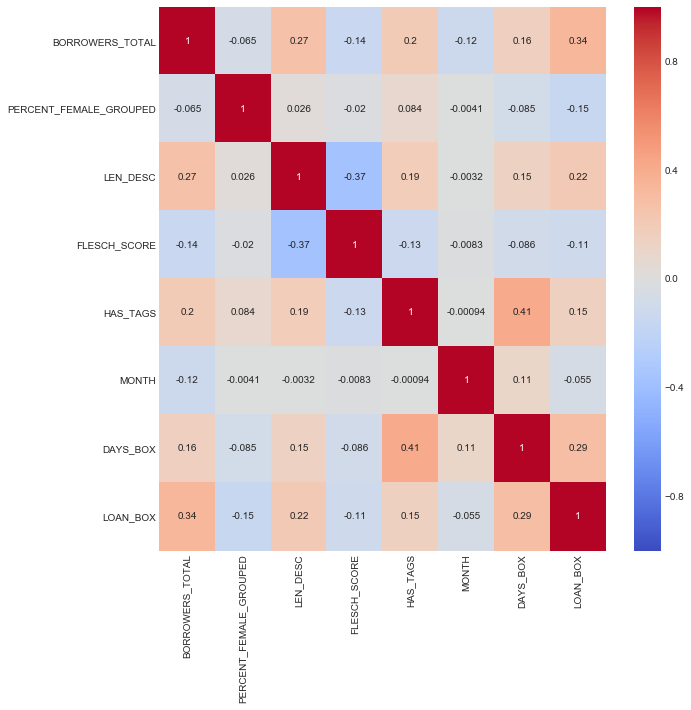

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(Kiva_CV.drop(['LOAN_AMOUNT','DAYS_TO_FUND'],1).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True, ax=ax)

In [ ]:
#sns.pairplot(Kiva_CV.drop(['LOAN_AMOUNT','DAYS_TO_FUND'],1))

## Create X/Y

In [ ]:
#sns.pairplot(Kiva_CV)

In [14]:
y = Kiva_CV.dropna()['DAYS_BOX']
X = Kiva_CV.dropna().drop(['DAYS_BOX', 'PARTNER_ID', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)


In [15]:
Dummy = patsy.dmatrix('SECTOR_NAME', data=Kiva_CV, return_type='dataframe')
#Dummy_2 = patsy.dmatrix('PARTNER_ID', data=Kiva_CV, return_type='dataframe')


In [ ]:
#Dummy_2.columns

In [16]:
X = X.join(Dummy)
#X = X.join(Dummy_2.drop(['Intercept'],1))


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)


In [18]:
model= LinearRegression()
model.fit(X_train,y_train)
print('LinearRegression training',model.score(X_train,y_train))
print('LinearRegression testing',model.score(X_test,y_test))

model.fit(X_train,y_train)
print('Train Test Split training', model.score(X_train,y_train))
print('Train Test Split testing', model.score(X_test,y_test))
reg = LinearRegression()

scores = cross_val_score(reg, X, y, cv=10, scoring='r2')
print('Cross Validation', np.mean(scores))


LinearRegression training 0.2782361953950109
LinearRegression testing 0.27832673661595864
Train Test Split training 0.2782361953950109
Train Test Split testing 0.27832673661595864
Cross Validation 0.2701029782135722


## Polynomial Fit for Linear Regression

In [21]:
# #create a 2 degree polynomial and run linear regression on training data.
# degree = 2
# est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# est.fit(X_train,y_train)
# est.score(X_train,y_train)


0.3612092137408124

In [22]:
# est.score(X_test, y_test)


0.27294561318917787

In [23]:
# degree = 3
# est = make_pipeline(PolynomialFeatures(degree), RidgeCV())
# est.fit(X,y)
# est.score(X,y)

0.3921159941421931

In [24]:
# degree = 3
# est = make_pipeline(PolynomialFeatures(degree), LassoCV())
# est.fit(X,y)
# est.score(X,y)

0.2744834821621428

In [128]:
degree = 3
l1rat = [0,.1,.2,.5, .7, .9, .95, .99, 1]
α = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]
est = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio=l1rat, alphas=α))
est.fit(X,y)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('elasticnetcv', ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
       copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0))])

In [129]:
print("alpha =", est.named_steps.elasticnetcv.alpha_, "l1_ratio =",
      est.named_steps.elasticnetcv.l1_ratio_)

alpha = 0.1 l1_ratio = 0.7


In [130]:
coef_df = pd.DataFrame()

In [131]:
poly = est.steps[0][1]
coef_df['feature'] = poly.get_feature_names(X.columns)
coef_df['coefficient'] = est.steps[-1][1].coef_.ravel()
coef_df[coef_df['coefficient'] != 0].sort_values('coefficient')

,feature,coefficient
716,FLESCH_SCORE HAS_TAGS Intercept,-0.029241
1208,LOAN_BOX^3,-0.016901
902,HAS_TAGS MONTH^2,-0.014740
770,FLESCH_SCORE Intercept SECTOR_NAME[T.Food],-0.014085
725,FLESCH_SCORE HAS_TAGS SECTOR_NAME[T.Manufactur...,-0.013220
717,FLESCH_SCORE HAS_TAGS SECTOR_NAME[T.Arts],-0.012979
729,FLESCH_SCORE HAS_TAGS SECTOR_NAME[T.Transporta...,-0.011848
723,FLESCH_SCORE HAS_TAGS SECTOR_NAME[T.Health],-0.010141
759,FLESCH_SCORE LOAN_BOX SECTOR_NAME[T.Personal Use],-0.009387
541,PERCENT_FEMALE_GROUPED MONTH^2,-0.007968


In [133]:
pred_y = est.predict(X)
est.score(X,y)

0.34939144309841397

In [102]:
data.columns

Index(['DAYS_BOX', 'predict', 'resid', 'res_trans', 'pred_trans'], dtype='object')

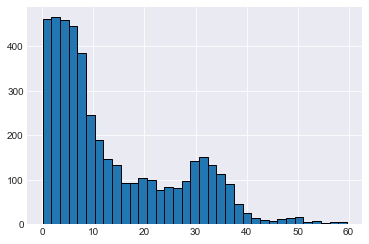

In [134]:
data.DAYS.hist(bins=35)

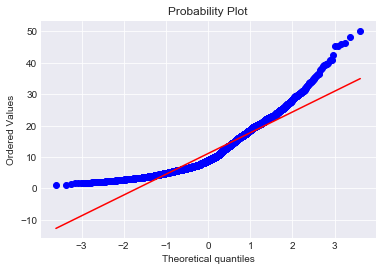

In [135]:
stats.probplot(data['pred_trans'], dist='norm', plot=plt);

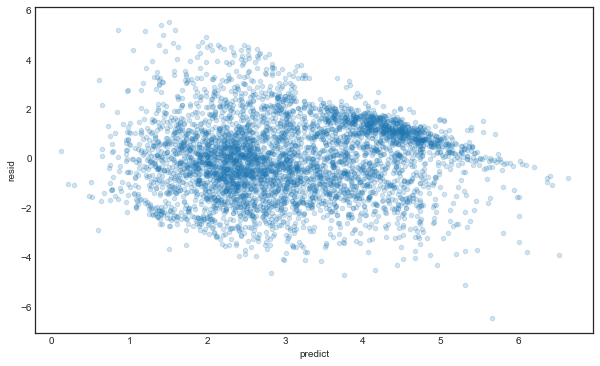

In [86]:
data = pd.DataFrame(y)
data['predict'] = est.predict(X)
data['resid'] = (data['DAYS_BOX'] - data['predict'])

with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',
                  y='resid',
                  alpha=.2,
                  figsize=(10,6),)

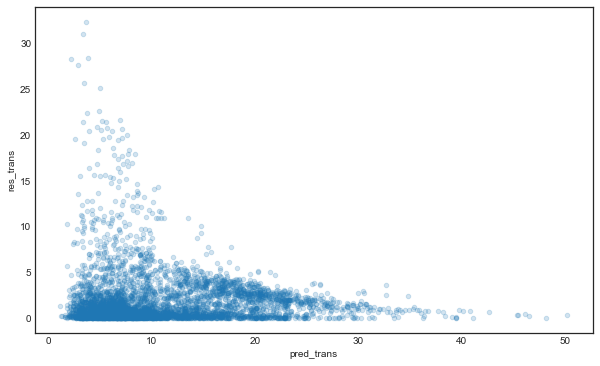

In [109]:
data = pd.DataFrame(y)
data['predict'] = est.predict(X)
data['resid'] = (data['DAYS_BOX'] - data['predict'])
data['res_trans'] = inv_boxcox(data['resid'], lmb_days)
data['pred_trans'] = inv_boxcox(data['predict'], lmb_days)
data['DAYS'] = inv_boxcox(data['DAYS_BOX'], lmb_days)

with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='pred_trans',
                  y='res_trans',
                  alpha=.2,
                  figsize=(10,6),)

In [90]:
mse = mean_squared_error(y, pred_y)
rmse = mse**.5

In [153]:
coef_df

,feature,coefficient
0,1,0.000000
1,BORROWERS_TOTAL,0.000000
2,PERCENT_FEMALE_GROUPED,0.000000
3,FLESCH_SCORE,-0.000000
4,HAS_TAGS,-0.000000
5,MONTH,0.000000
6,LOAN_BOX,-0.000000
7,Intercept,0.000000
8,SECTOR_NAME[T.Arts],-0.000000
9,SECTOR_NAME[T.Clothing],0.000000


In [149]:
(1-est.score(X,y))*(len(X)-1)

2903.0153808948767

In [152]:
(len(X)-len(coef_df)-1)

2438

In [154]:
r2_adj = 1 - ((1-est.score(X,y))*(len(X)-1)/(len(X)-99-1))

In [155]:
r2_adj

0.3346286085503377

In [29]:
print("alpha =", est.named_steps.elasticnetcv.alpha_, "l1_ratio =", est.named_steps.elasticnetcv.l1_ratio_)

alpha = 0.1 l1_ratio = 0.7


In [ ]:
lm1 = smf.ols('DAYS_BOX ~ LOAN_BOX + SECTOR_NAME + BORROWERS_TOTAL + MONTH + PERCENT_FEMALE_GROUPED + HAS_TAGS + FLESCH_SCORE', data=Kiva_Kenya)
fit1 = lm1.fit()
fit1.summary()

y_sm = Kiva_CV['DAYS_BOX']
X_sm = Kiva_CV.drop(['DAYS_BOX', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
y_sm_pat, X_sm_pat = patsy.dmatrices('DAYS_BOX ~ LOAN_BOX + BORROWERS_TOTAL + MONTH + PERCENT_FEMALE_GROUPED + FLESCH_SCORE + HAS_TAGS + SECTOR_NAME', data=Kiva_CV, return_type="dataframe")
X_smc=sm.add_constant(X_sm)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm_pat, y_sm_pat, test_size=.3)

In [ ]:
lm1 = sm.OLS(y_train_sm, X_train_sm)
fit1 = lm1.fit()
fit1.summary()
#y_pred = fit1.predict(X_test_sm)

In [ ]:
#fit1.params

In [ ]:
# plt.plot(y_pred)
# plt.ylabel('Count')
# plt.xlabel('Normalized residuals')

In [ ]:
#sns.residplot()

## Adjusted $R^2$ calculation

r2_adj = 1 - ((sum((y_test-results.predict(X_test))**2.0)/(len(X_test) - len(results.params) - 1))
                /(sum((y_test - np.mean(y_test))**2.0)/(len(X_test) - 1)))    #compute the adjusted r2 in the test set

## Ridge CV

In [30]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
y_ridge = Kiva_CV['DAYS_BOX']
X_ridge = Kiva_CV.drop(['DAYS_BOX', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
Dummy_ridge = patsy.dmatrix('SECTOR_NAME', data=Kiva_CV, return_type='dataframe')
X_ridge = X_ridge.join(Dummy_ridge)
X_train_intermediate, X_test_ridge, y_train_intermediate, y_test_ridge = train_test_split(X_ridge, y_ridge, test_size=.3)
X_train_ridge, X_validation_ridge, y_train_ridge, y_validation_ridge = train_test_split(X_train_intermediate, y_train_intermediate, test_size=.3)

In [ ]:
alphas = [0.001, 0.01, 0.1, 1, 10]
print('All errors are RMSE')
print('-'*76)
for alpha in alphas:
    # instantiate and fit model
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(X_train_ridge, y_train_ridge)
    # calculate errors
    new_train_error = mean_squared_error(y_train_ridge, ridge.predict(X_train_ridge))
    new_validation_error = mean_squared_error(y_validation_ridge, ridge.predict(X_validation_ridge))
    new_test_error = mean_squared_error(y_test_ridge, ridge.predict(X_test_ridge))
    # print errors as report
    print('alpha: {:7} | train error: {:5} | val error: {:6} | test error: {}'.
          format(alpha,
                 round(new_train_error,3),
                 round(new_validation_error,3),
                 round(new_test_error,3)))

In [ ]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse

In [ ]:
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ridge, y_ridge, test_size=0.3)

# instantiate model
ridge = Ridge(alpha=1, fit_intercept=True)

# fit and calculate errors
new_train_error, new_test_error = calc_metrics(X_train, y_train, X_test, y_test, ridge)
new_train_error, new_test_error = round(new_train_error, 3), round(new_test_error, 3)

In [ ]:
new_test_error, new_train_error

In [ ]:
degree = 2
est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1))
est.fit(X_train,y_train)
est.score(X_train,y_train), est.score(X_test, y_test)

In [ ]:
rcv = RidgeCV(alphas = (1e-2,1e-1,1e0,1e1), cv=10)

In [ ]:
rcv.fit(X_train,y_train)

In [ ]:
rcv.score(X_train, y_train), rcv.score(X_test,y_test)


In [ ]:
ridge = Ridge(alpha=1)
ridge_coef = ridge.fit(X, y).coef_
_ = plt.plot(range(len(X.columns)), ridge_coef)
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=90)
_ = plt.ylabel('Coefficients')
plt.tight_layout()
plt.show()

## Lasso CV

In [42]:
y_lasso = Kiva_CV.dropna()['DAYS_BOX']
X_lasso = Kiva_CV.dropna().drop(['DAYS_BOX', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
Dummy_lasso = patsy.dmatrix('SECTOR_NAME', data=Kiva_CV, return_type='dataframe')
X_lasso = X_lasso.join(Dummy_lasso)
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=.3)

In [53]:
#test 6 different alpha values for the dataset, choose alpha to use that produces lowest error.
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
val_errors = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    errors = np.sum(-cross_val_score(lasso, 
                                     X= X, 
                                     y= y, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10))
    val_errors.append(np.sqrt(errors))
val_errors    
alpha_to_use = alphas[val_errors.index(min(val_errors))]

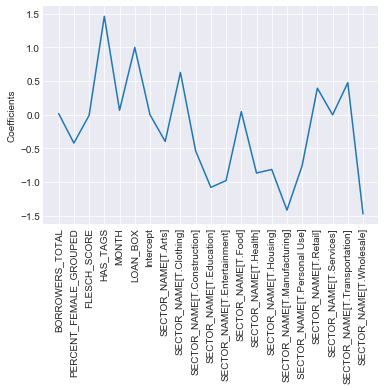

In [51]:
lasso = Lasso(alpha=alpha_to_use)
lasso_coef = lasso.fit(X, y).coef_
_ = plt.plot(range(len(X.columns)), lasso_coef)
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=90)
_ = plt.ylabel('Coefficients')
plt.show()

In [55]:
degree = 3
est = make_pipeline(PolynomialFeatures(degree), Lasso())
est.fit(X,y)
est.score(X,y)

0.3208099016894749

In [ ]:
l1rat = [0,.1,.2,.5, .7, .9, .95, .99, 1]
alphas = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]
elastic = ElasticNetCV(l1_ratio=l1rat, alphas = alphas, cv=10)

In [ ]:
elastic1 = elastic.fit(X_train, y_train)
elastic1.score(X_train, y_train), elastic1.score(X_test, y_test)


In [ ]:
X_test.columns

In [ ]:
data = pd.DataFrame(y_test)
data['predict'] = elastic1.predict(X_test)
data['resid'] = (data['DAYS_BOX'] - data['predict'])

with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',
                  y='resid',
                  alpha=.2,
                  figsize=(10,6),)

In [ ]:
degree =2
l1rat = [0,.1,.2,.5, .7, .9, .95, .99, 1]
alphas = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]
elast = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio=l1rat, alphas = alphas, cv=10))
elast.fit(X_train, y_train)

In [ ]:
elast.score(X_train, y_train), elast.score(X_test, y_test)

In [ ]:
data2 = pd.DataFrame(y_test)
data2['predict'] = elast.predict(X_test)
data2['resid'] = (data2['DAYS_BOX'] - data2['predict'])

with sns.axes_style('white'):
    plot=data2.plot(kind='scatter',
                  x='predict',
                  y='resid',
                  alpha=.2,
                  figsize=(10,6),)

In [ ]:
lcv = LassoCV(cv=10)

In [ ]:
lcv.fit(X_train,y_train)

lcv.score(X_train, y_train), lcv.score(X_test,y_test)

In [ ]:
sns.residplot(x='LOG_FUNDED', y='DAYS_BOX', data=Kiva_Kenya)

In [ ]:
sns.residplot(x='LOG_FUNDED', y='DAYS_TO_FUND', data=Kiva_Kenya)

In [ ]:
plt.plot(fit1.resid)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

In [ ]:
lm1 = smf.ols('DAYS ~ LOAN_AMOUNT + BORROWERS_TOTAL + PRIMARY_GENDER + COUNTRY_NAME + SECTOR_NAME', data=kiva)
fit1 = lm1.fit()
fit1.summary()

# Old Stuff

In [ ]:
#create a plot of number of lenders vs total funded amount by year
#kenya_plot = sns.lmplot(x='DAYS' data=Kiva_Kenya, hue = 'PRIMARY_GENDER', col='YEAR', palette='coolwarm',
#          aspect=.6, size=8)
#axes = kenya_plot.axes
#axes[0,0].set_xlim(0,40)

In [ ]:
#sns.jointplot(x='DAYS', y='PRIMARY_GENDER', data=Kiva_Kenya, kind='reg')

In [ ]:
#create a new dataframe with no null values
kiva_no_null = kiva2.dropna()

In [ ]:
kiva_no_null.drop(['LOAN_ID'], axis=1).groupby(['COUNTRY_NAME', 'SECTOR_NAME', 'STATUS','YEAR']).mean()

In [ ]:
#create a plot of number of lenders vs total funded amount by year
lm = sns.lmplot(x='NUM_LENDERS_TOTAL', y='DAYS', data=kiva_no_null, col='YEAR', palette='coolwarm',
          aspect=.6, size=8)
axes = lm.axes
axes[0,0].set_xlim(0,300)

In [ ]:
sns.jointplot(x='DAYS', y='DoW', data=kiva2, kind='scatter', alpha=.05)

In [ ]:
sns.jointplot(x='DAYS', y='LOG_FUNDED', data=kiva2, kind='scatter', alpha=.2)

In [ ]:
kiva2.info()

In [ ]:
grouping = kiva2.drop(['LOAN_ID'], axis=1).groupby(['COUNTRY_NAME', 'SECTOR_NAME', 'STATUS','YEAR','NUM_LENDERS_TOTAL']).mean()

In [ ]:
#lr =LinearRegression()

#X=kiva3[['FUNDED_AMOUNT','LENDER_TERM', 'NUM_LENDERS_TOTAL', 'FEMALE_BORROWERS', 'BORROWERS_TOTAL', 'DoW',]]
#y=kiva3['DAYS']

#lr.fit(X,y)

In [ ]:
kiva3=kiva2.dropna()

In [ ]:
lm1 = smf.ols('DAYS ~ FUNDED_AMOUNT + LENDER_TERM + NUM_LENDERS_TOTAL + FEMALE_BORROWERS + BORROWERS_TOTAL + DoW', data=kiva3)
fit1 = lm1.fit()
fit1.summary()

In [ ]:
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_partregress_grid(fit1, fig=fig)
#plt.savefig('Partial_Regression.png', dpi=300)

In [ ]:
X = patsy.dmatrix('COUNTRY_NAME',data=kiva3,return_type='dataframe')
X.head()

In [ ]:
kiva_country = kiva3.join(X)

In [ ]:
kiva3.info()

In [ ]:
kiva_country.head

In [ ]:
kiva_country.drop(['LOAN_NAME', 'LOAN_AMOUNT','ACTIVITY_NAME','COUNTRY_NAME','POSTED_TIME','DISBURSE_TIME','DISTRIBUTION_MODEL'], axis=1, inplace=True)

In [ ]:
kiva_country.drop(['NUM_JOURNAL_ENTRIES','NUM_BULK_ENTRIES','BORROWER_GENDERS'], axis=1, inplace=True)

In [ ]:
kiva_country.drop(['RAISED_TIME'], axis=1, inplace=True)

In [ ]:
kiva_country.columns

In [ ]:
kiva3.to_pickle('kiva3.pkl')`

In [ ]:
kiva_country.to_pickle('kiva_country.pkl')

In [ ]:
X= kiva_country.drop(['LOAN_ID', 'STATUS', 'SECTOR_NAME','REPAYMENT_INTERVAL','TIME_DELTA', "YEAR"],1)
y=kiva_country.DAYS

In [ ]:
lr = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

In [ ]:
lm2 = sm.OLS(y,X)
fit2 = lm2.fit()
fit2.summary()

In [ ]:
fit2.resid.plot(style='o', figsize=(10,10), alpha=.05)

In [ ]:
#sns.regplot(x=X, y=y, data=kiva3)

In [ ]:
#fig = plt.figure(figsize=(10,10))
#sm.graphics.plot_partregress(y, X, kiva_country['YEAR'])

In [ ]:
kiva3=kiva2.join(X)

In [ ]:
p = lm1.fit().params

In [ ]:
kiva3['YEAR'] = kiva3['POSTED_TIME'].dt.year

In [ ]:
#Below here is exploratory data looking at things that did not receive funding. But not the direction I am going to go in.

In [ ]:
#This creates a column with a 1 for a project primarily feature females and 0 for a project primarily featuring males
#kiva_no_NA['PRIMARY_GENDER'][(kiva_no_NA['FEMALE_BORROWERS'] - kiva_no_NA['MALE_BORROWERS'] >=0)] = 1
#kiva_no_NA['PRIMARY_GENDER'][((kiva_no_NA['FEMALE_BORROWERS'] - kiva_no_NA['MALE_BORROWERS']) <0)] = 0

In [ ]:
#kiva_no_NA['PRIMARY_GENDER'].value_counts()

In [ ]:
#kiva_not_funded = kiva3[(kiva3['DAYS'].isnull())]

In [ ]:
#kiva_not_funded.head()

In [ ]:
#kiva_not_funded['COUNTRY_NAME'].value_counts()

In [ ]:
#kiva_not_funded['YEAR'] = kiva_not_funded['POSTED_TIME'].dt.year

In [ ]:
#kiva_not_funded['YEAR'].value_counts()

In [ ]:
#kiva3['SECTOR_NAME'].value_counts()

In [ ]:
#percent_not_funded = kiva_not_funded['SECTOR_NAME'].value_counts() / kiva3['SECTOR_NAME'].value_counts()

In [ ]:
#maybe something to look into more? is type of project an indicator in funding or not?
#percent_not_funded

In [ ]:
#country_not_funded_percent = kiva_not_funded['COUNTRY_NAME'].value_counts() / kiva3['COUNTRY_NAME'].value_counts()

In [ ]:
#Some countries have 100% not funded rate... but I also assume those countries have very few applications (1).
#I am sure this is something that needs a weighted measurement for prediction, but not sure how to capture it.
#Also this is just a small sample of 50k out of 1.4 million appplications total.
#country_not_funded_percent.dropna()

In [ ]:
#year_not_funded_percent = kiva_not_funded['YEAR'].value_counts() / kiva3['YEAR'].value_counts()

In [ ]:
#year_not_funded_percent

In [ ]:
X=kiva2[['FUNDED_AMOUNT']]
y=kiva2.DAYS

In [ ]:
X=sm.add_constant(X)

In [ ]:
est = sm.OLS(y,X).fit()

In [ ]:
xx1,xx2 = np.meshgrid(np.linspace(X.FUNDED_AMOUNT.min()))

In [ ]:
lm1 = smf.ols('DAYS ~ FUNDED_AMOUNT + LENDER_TERM + NUM_LENDERS_TOTAL + FEMALE_BORROWERS + BORROWERS_TOTAL + DoW', data=kiva3)
fit1 = lm1.fit()
fit1.summary()

#Outdated, but keeping to have record of initial efforts
```Python
df_agg = kiva2.groupby(['COUNTRY_NAME'])['SECTOR_NAME'].value_counts().unstack()
df_agg.plot(kind='bar', stacked=True, figsize=(16,16))
```

#Old formatting, preserved for ability to look back at later.
```Python

kiva.drop(['NUM_BULK_ENTRIES'], axis=1, inplace=True)
kiva.drop(['DoW'], axis=1, inplace=True)
kiva.drop(['NUM_JOURNAL_ENTRIES'], axis=1, inplace=True)
kiva.drop(['ACTIVITY_NAME'], axis=1, inplace=True)
kiva.drop(['DISBURSE_TIME'], axis=1, inplace=True)
kiva.drop(['LOAN_NAME'], axis=1, inplace=True)
kiva.drop(['LENDER_TERM'], axis=1, inplace=True)
kiva.drop(['POSTED_TIME', 'RAISED_TIME','TIME_DELTA', 'REPAYMENT_INTERVAL'], axis=1, inplace=True)

```